# Quick notebook for testing T-SAM with new optimal OVAM embeddings


In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import torch

In [3]:
# general imports
import numpy as np
import pandas as pd
import torch

from diffusers import StableDiffusionPipeline

import os
import shutil

print(torch.version.cuda)

12.1


In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

#### TSAM imports based on run python file

In [5]:
# the following code enables imports from the folders in the repository
# NOTE: this only affects the active kernel, not actual system path
import sys
from pathlib import Path

project_root = Path.cwd().parent.parent
sys.path.insert(0, str(project_root))

In [6]:
print(project_root)

C:\Users\brandon\Documents\CS 5864\CS5864-diffusion-control


In [7]:
import matplotlib.pyplot as plt
import torch
import os
import torch.nn.functional as F
from typing import List


from tsam.utils import (load_model,
                       save_image,
                       save_text_sa_avg,
                       get_token_ids,
                       LatentOptConfig)

import argparse
import yaml

from tsam.logger.bias_logger import BiasLogger

$$ $$

$$ $$

$$ $$

## Model load in based on run file

In [8]:
from tsam.run import run_one_prompt

In [9]:
with open('../../tsam/configs/config.yaml','r') as f:
    config_dict = yaml.safe_load(f)
    
latent_opt_config = LatentOptConfig(**config_dict)


pipe = load_model(model_name='sd1_5x_2', device='cuda')


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


$$ $$

# Load optimized embedding files

**NOTE:** The optimized embeddings for "male" are (2,768) since they also include the start token, so I index to take the second token, which should be the one we care about

In [10]:
#opt_male = np.load('optimal_male_embedding.npy')[1]
#opt_female = np.load('optimal_female_embedding.npy')[1]

In [11]:
#opt_male.shape

$$ $$

## Overview for creating optimized male and female prompts

Simply:
- encode a prompt: ____ "male"
- replace the "male" embedding with the opt_male embedding

This probably screws with the attention matrices within the encoder, but should be fine for us.

$$ $$

I'm going to do all this in the TSAM code with the following dictionary list input for a bias:

[male_bias, female_bias]

each dictionary has:
- word : male/female
- opt_embedding : numpy (768,)

we will also take in an argument of a bias prompt in the form "a photo of a {}"


$$ $$

$$ $$

$$ $$

In [12]:
# do run_one_prompt code with reduced version
def bias_reduced_generation(main_prompt, occupation_info, bias_prompt_form, bias_info, bias_ratio_goal, logger, num_inference_steps=50, seed=1234):

    pipe.text_encoder.to("cuda")

    # sd 1.5 option
    pipe.attn_fetch_x.set_processor(unet = pipe.unet)

    steps_to_save_attention_maps = list(range(num_inference_steps))

    max_iter_to_alter = latent_opt_config.max_iter_to_alter
    iterative_refinement_steps = latent_opt_config.iterative_refinement_steps

    if not latent_opt_config.update_latent:
        max_iter_to_alter = 0
        iterative_refinement_steps = []

    image, all_maps = pipe.bias_reduced_call(
        prompt=main_prompt,
        generator=torch.Generator("cuda").manual_seed(seed),
        num_inference_steps=num_inference_steps,
        max_iter_to_alter=max_iter_to_alter,
        steps_to_save_attention_maps=steps_to_save_attention_maps,
        latent_opt_config = latent_opt_config,

        bias_prompt_form=bias_prompt_form,
        bias_info=bias_info,
        occupation_info=occupation_info,
        logger=logger,
        bias_ratio_goal=bias_ratio_goal
    )

    return image, all_maps

$$ $$

$$ $$

## Bias generation setup


Current attributes used from latent_opt_config:
- show_first_bias_map
    - Whether to display UNet cross attentions at beginning of bias reduction iterations
- show_last_bias_map
    - Whether to display UNet cross attentions after bias reduction iterations
- bias_refinement_steps
    - List of generation steps to run bias reduction iteration loop
- bias_loss_threshold
    - float loss threshold for when to break bias loss iteration loop
    - 


$$ $$
latent_opt_config.bias_loss_function_details is a dictionary with the following optional keys
   - display: all or one
       - whether to display all UNet cross attention layers or just the ones being used for loss function
   - separate_scales: True or False, default False
       - whether the groups of displayed cross attention maps should use the same color scale
   - max_cnt: int, default 30
       - maximum interation count for bias loss iterations
   - block_class: None, 'CrossAttnUpBlock2D' or 'CrossAttnDownBlock2D'
       - block class to grab cross attentions from
       - None defaults to T-SAM default of using both bottle neck layers
       - **NOTE:** I haven't implemented being able to choose multiple UNet blocks or interpolating between them
   - total_map_size: 16\*16, 32\*32, 64\*64
       - total map size of desired cross attention layer (s*s)
       - not required if block_class is None


In [13]:
# disable T-SAM iterative function
latent_opt_config.iterative_refinement_steps = [] #[5, 7, 9]

# choose when to disable T-SAM normal steps
latent_opt_config.max_iter_to_alter = 1

# bias map display settings
latent_opt_config.show_first_bias_map = True
latent_opt_config.show_last_bias_map = True


# default TSAM step_size goes from 5 to 3.5 over 50 steps
latent_opt_config.bias_refine_step_info = {
    #   adjust  max_cnt   step_size_mult    # avg mult
    5: [1,      20,       4,                0.05],
    #6: [1,      10,       4,                0.05],
    #7: [1,      10,       4,                0.05],
    #8: [1,      10,       4,                0.05],
    #9: [1,      10,       4,                0.05],
   #10: [1,      10,       4,                0.05],
   #12: [1,      7,       2,                1],
   #14: [1,      15,       2,                1],
   #16: [1,      15,       2,                1]
}

latent_opt_config.bias_refinement_steps = list(latent_opt_config.bias_refine_step_info.keys())

#latent_opt_config.bias_refinement_steps = [i for i in range(5, 12, 1)]
latent_opt_config.bias_refinement_steps = []

latent_opt_config.bias_loss_function_details = {'display' : 'one',                      # 'all' or default of one
                                                'separate_scales': True,                # True or default of None/False
                                                'block_class': 'CrossAttnUpBlock2D',    # None, 'CrossAttnUpBlock2D' or 'CrossAttnDownBlock2D'
                                                'total_map_size': [16*16],              #  None, 16*16, 32*32, or 64*64
                                                'max_cnt' : 15,
                                                'do_TSAM_after': True}

latent_opt_config.bias_loss_threshold = 0.01 #0.01


main_prompt = "A photo of the face of a nurse"

occupation_info = {'word' : 'nurse'}

bias_prompt_form = "A photo of a {}"
bias_info = [{'word' : 'male',   'opt_embedding' : None},
             {'word' : 'female', 'opt_embedding' : None}]

logger = BiasLogger('', vae=pipe.vae, image_processor=pipe.image_processor)

# for nurse,  1.625 times female
bias_ratio_goal = 1.6 # first bias / second bias

image, attention_maps = bias_reduced_generation(main_prompt, occupation_info, bias_prompt_form, bias_info, bias_ratio_goal, logger=logger, num_inference_steps=20, seed=1234)

num_warmup_steps: 1


  0%|          | 0/20 [00:00<?, ?it/s]

C:\Users\brandon\anaconda3\envs\tsam\lib\site-packages\torch\functional.py:534: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at C:\cb\pytorch_1000000000000\work\aten\src\ATen\native\TensorShape.cpp:3596.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


Iter 0, T-SAM attn loss: 1.796875
updated latent (step 0)
Iter 1, T-SAM attn loss: 1.791015625
Iter 2, T-SAM attn loss: 1.7900390625
Iter 3, T-SAM attn loss: 1.7900390625
Iter 4, T-SAM attn loss: 1.7861328125
Iter 5, T-SAM attn loss: 1.7705078125
Iter 6, T-SAM attn loss: 1.7705078125
Iter 7, T-SAM attn loss: 1.748046875
Iter 8, T-SAM attn loss: 1.76171875
Iter 9, T-SAM attn loss: 1.7490234375
Iter 10, T-SAM attn loss: 1.7392578125
Iter 11, T-SAM attn loss: 1.7236328125
Iter 12, T-SAM attn loss: 1.71484375
Iter 13, T-SAM attn loss: 1.7099609375
Iter 14, T-SAM attn loss: 1.7080078125
Iter 15, T-SAM attn loss: 1.71484375
Iter 16, T-SAM attn loss: 1.724609375
Iter 17, T-SAM attn loss: 1.7412109375
Iter 18, T-SAM attn loss: 1.755859375
Iter 19, T-SAM attn loss: 1.775390625
Iter 20, T-SAM attn loss: 1.8134765625


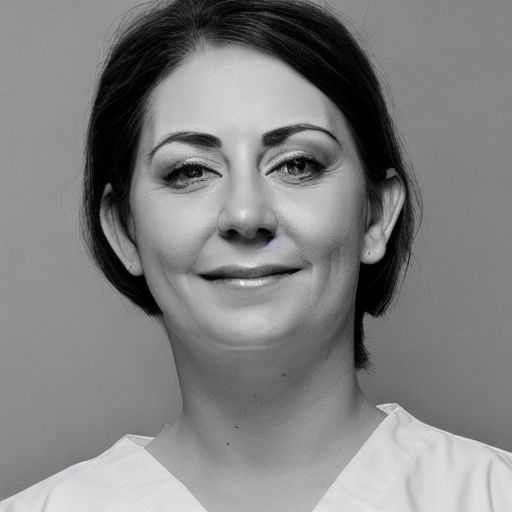

In [14]:
image[0]

In [14]:
pipe.scheduler.

PNDMScheduler {
  "_class_name": "PNDMScheduler",
  "_diffusers_version": "0.35.2",
  "beta_end": 0.012,
  "beta_schedule": "scaled_linear",
  "beta_start": 0.00085,
  "clip_sample": false,
  "num_train_timesteps": 1000,
  "prediction_type": "epsilon",
  "set_alpha_to_one": false,
  "skip_prk_steps": true,
  "steps_offset": 1,
  "timestep_spacing": "leading",
  "trained_betas": null
}

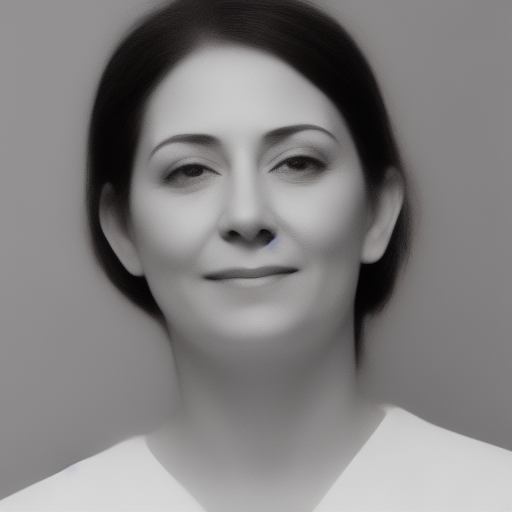

In [19]:
logger._images[9]

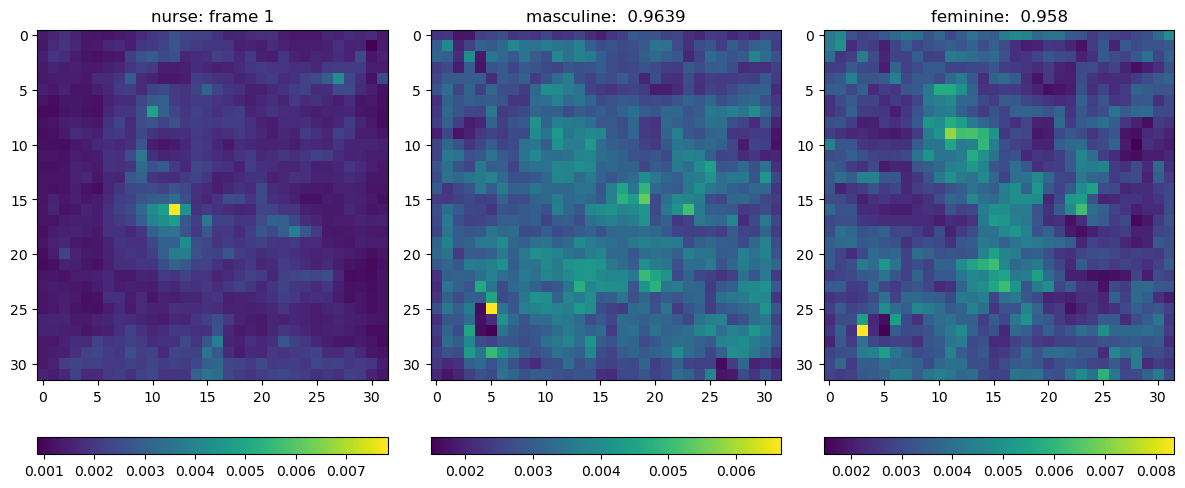

In [14]:
logger.attention_plots[1]

In [15]:
logger._write_mp4(logger.attention_plots, "adj_ca_animation.mp4", fps=1)

IMAGEIO FFMPEG_WRITER WARNING: input image is not divisible by macro_block_size=16, resizing from (1190, 480) to (1200, 480) to ensure video compatibility with most codecs and players. To prevent resizing, make your input image divisible by the macro_block_size or set the macro_block_size to 1 (risking incompatibility).


WindowsPath('adj_ca_animation.mp4')

In [16]:
logger._write_mp4(logger._images, "adj_image_animation.mp4", fps=1)

WindowsPath('adj_image_animation.mp4')

$$ $$

# Analyzing test folders

In [28]:
test_folder_path = "../../../bias_tests/v2_updated/"

data_folder = Path(test_folder_path)

test_folders = [f.name for f in data_folder.iterdir() if f.is_dir()]

In [29]:
test_folders

['nurse_base_updated',
 'test_bias1_updated',
 'test_bias2_updated',
 'test_bias3_updated',
 'test_bias4_updated',
 'test_bias5_updated',
 'test_bias6_updated',
 'test_bias7_updated']

$$ $$

## Print overall info for each folder (for table)

In [52]:
def look_at_folder(test_folder):
    # load in gender df
    gender_df = pd.read_excel(test_folder / "fairness.xlsx")

    # load in cmmd numpy array
    cmmd = np.load(test_folder / "cmmd.npy")

    # load in config
    with open(test_folder / "config.yaml",'r') as f:
        curr_config_dict = yaml.safe_load(f)

    if 'bias_refine_step_info' in curr_config_dict:
        method_info = curr_config_dict['bias_refine_step_info']
    else:
        method_info = None

    print(test_folder.name)

    if method_info:
        steps = method_info.keys()
        print("step:", steps)
        print("avg_mult:", [method_info[step][3] for step in steps])
        
    else:
        print()

    print()
    print(f"man: {gender_df['man'].mean():.4f}")
    print(f"woman: {gender_df['woman'].mean():.4f}")
    print()
    print(f"cmmd: {cmmd:.4f}") 


    print("\n\n")

In [53]:
for test_name in test_folders:
    look_at_folder(data_folder / test_name)

nurse_base_updated


man: 0.1949
woman: 0.8051

cmmd: 1.9543



test_bias1_updated
step: dict_keys([5])
avg_mult: [0.01]

man: 0.2582
woman: 0.7418

cmmd: 2.1504



test_bias2_updated
step: dict_keys([5])
avg_mult: [0.05]

man: 0.2770
woman: 0.7230

cmmd: 2.1203



test_bias3_updated
step: dict_keys([5])
avg_mult: [0.1]

man: 0.2800
woman: 0.7200

cmmd: 2.1250



test_bias4_updated
step: dict_keys([5])
avg_mult: [0.15]

man: 0.2595
woman: 0.7405

cmmd: 2.1040



test_bias5_updated
step: dict_keys([5])
avg_mult: [0.2]

man: 0.2532
woman: 0.7468

cmmd: 2.0925



test_bias6_updated
step: dict_keys([5])
avg_mult: [0.25]

man: 0.2361
woman: 0.7639

cmmd: 2.1237



test_bias7_updated
step: dict_keys([5])
avg_mult: [0.3]

man: 0.2408
woman: 0.7592

cmmd: 2.1002





## Create histogram of male to female distribution for each folder

In [83]:
def folder_gender_histogram(test_folder):
    # load in gender df
    gender_df = pd.read_excel(test_folder / "fairness.xlsx")

    # load in config
    with open(test_folder / "config.yaml",'r') as f:
        curr_config_dict = yaml.safe_load(f)

    if 'bias_refine_step_info' in curr_config_dict:
        method_info = curr_config_dict['bias_refine_step_info']
    else:
        method_info = None

    print(test_folder.name)

    
    if method_info:
        steps = method_info.keys()
        if len(steps) > 1:
            raise Exception("multiple bias loss steps")

        step = list(steps)[0]
        avg_mult = method_info[step][3]

    
    man_probs   = gender_df['man'].to_numpy()
    woman_probs = gender_df['woman'].to_numpy()

    bins = np.arange(0, 1.05, 0.05)
    
    # create histogram comparison plot
    plt.hist(man_probs,  bins=bins, density=False, alpha=0.45, label="man", color="blue")
    plt.hist(woman_probs, bins=bins, density=False, alpha=0.45, label="woman", color="red")
    plt.xlabel("Clip classification probability")
    plt.ylabel("Density")
    plt.legend(loc='upper center')

    if method_info:
        title_string = f"Gender distribution of bias loss, step = {step}, avg_mult = {avg_mult}"
    else:
        title_string = "Gender distribution of base generation"

    plt.title(title_string)

    plt.tight_layout()
    
    plt.savefig(test_folder / "gender_dist_histogram.jpg", dpi=300,  bbox_inches="tight")
    
    plt.show()

    print("\n\n")

nurse_base_updated


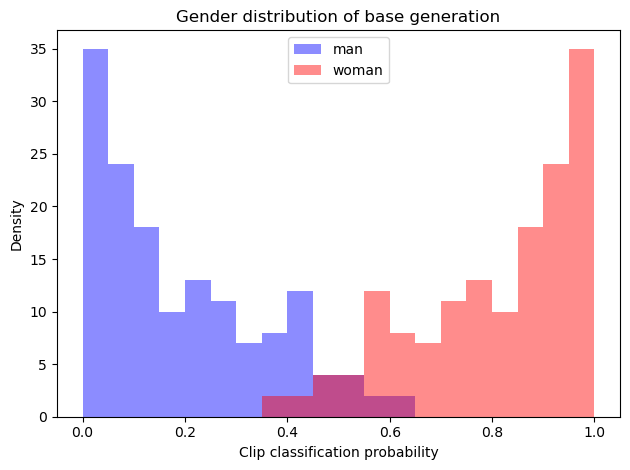




test_bias1_updated


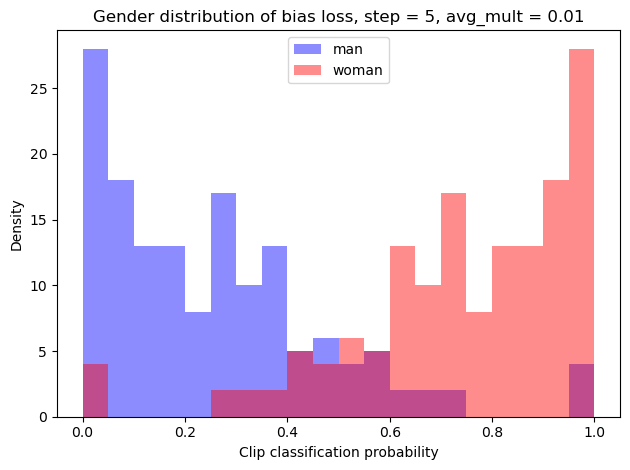




test_bias2_updated


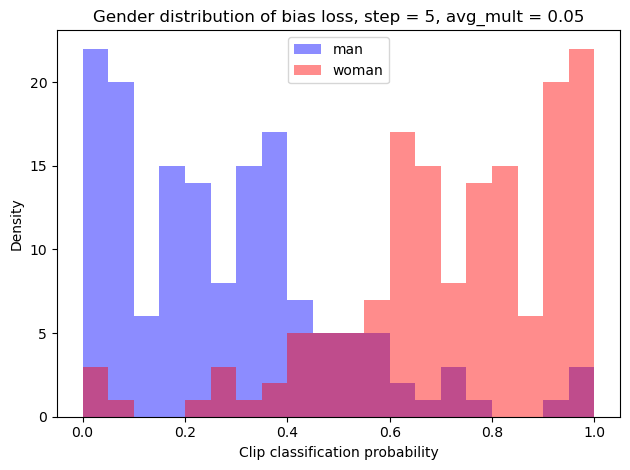




test_bias3_updated


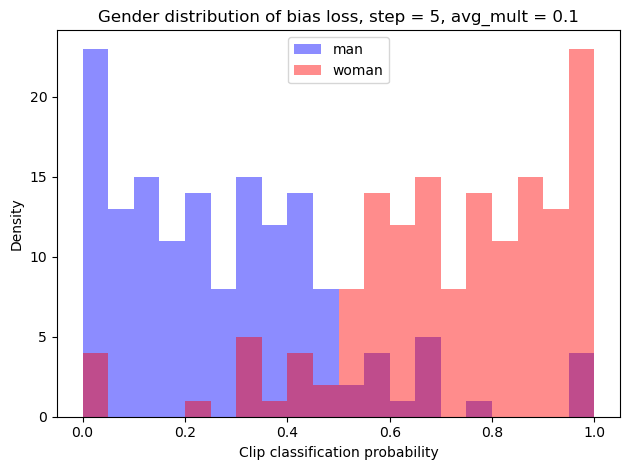




test_bias4_updated


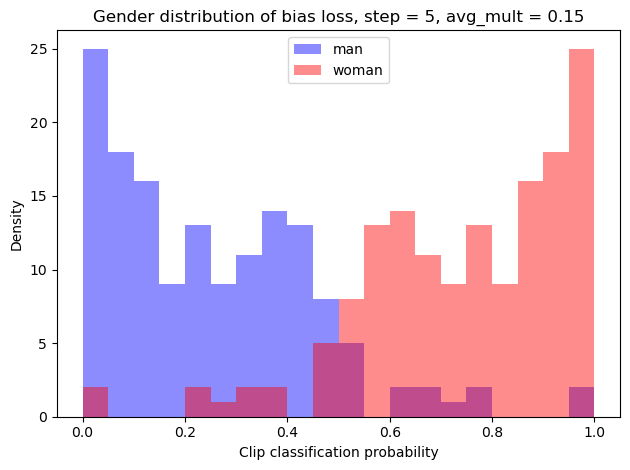




test_bias5_updated


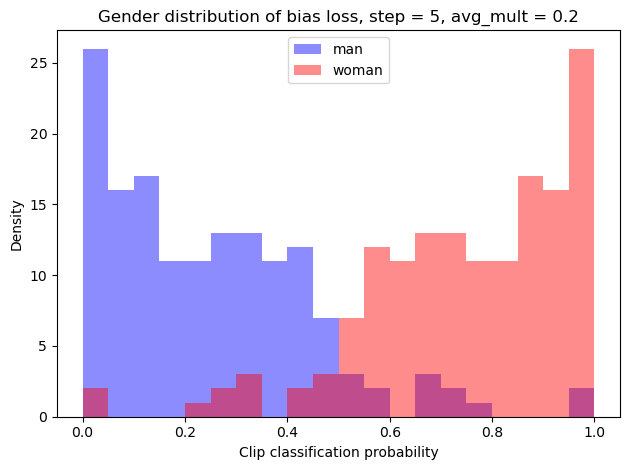




test_bias6_updated


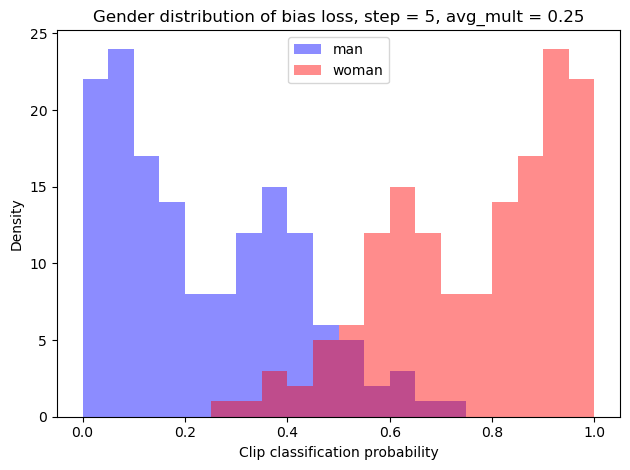




test_bias7_updated


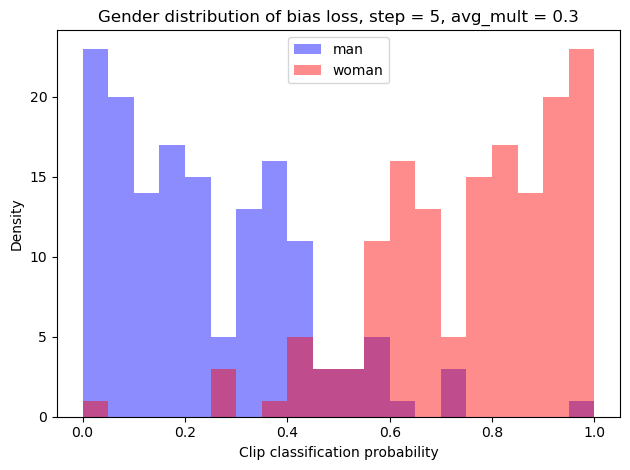

In [84]:
for test_name in test_folders:
    folder_gender_histogram(data_folder / test_name)

In [86]:
# zip all folders again

import shutil

for test_name in test_folders:

    curr_folder = data_folder / test_name

    # create 'my_archive.zip' that contains everything under 'my_folder'
    file_save = data_folder / (test_name[:-8])
    shutil.make_archive(str(file_save), 'zip', curr_folder)
